In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import time

from PIL import Image




In [2]:
bg_colour = (255,255,200)
width_tiles = 30
height_tiles = 30
grid_square = 70 #pixels per grid


In [3]:
def drawCoords(coords,img,color=(0,0,0)):
    """
    colours every pixel at a given coordinate in color
    """
    
    for x,y in coords:
        if (y >= img.height or y < 0 or x >= img.width or x < 0):
            pass
        else:
            img.putpixel((x,y),color)
            

def jitteryLine(start_coord, end_coord,spread=6, weight=1):
    """
    returns the coordinates for a straight line betwen start_coord and end_coord.
    The points of the line are normally distributed around the line with standard deviation of spread/6
    """
    x_length = end_coord[0]-start_coord[0]
    y_length = end_coord[1]-start_coord[1]
    try: m = y_length/x_length #gradient
    except: m=None
    
    coords = []
    mean_length= int((abs(x_length)+abs(y_length)/2))
    for i in range(0,weight):
        if(m==None):
            for y in np.linspace(start_coord[1],end_coord[1],num=mean_length):
                x = start_coord[0]
                jittery_x = rd.normal(loc=x, scale=spread/6)
                jittery_y = rd.normal(loc=y, scale=spread/6)
                coords.append([int(jittery_x),int(jittery_y)])
        else:
            for x in np.linspace(start_coord[0],end_coord[0],num=mean_length):
                y = m*x-m*start_coord[0]+start_coord[1] #equation of line
                jittery_x = rd.normal(loc=x, scale=spread/6)
                jittery_y = rd.normal(loc=y, scale=spread/6)
                coords.append([int(jittery_x),int(jittery_y)])
    return coords


def drawGrid(width_tiles,height_tiles,grid_square,color=(200,200,200)):
    coords =[]
    for tile in range(0,width_tiles):
        coords += (jitteryLine([tile*grid_square,0],[tile*grid_square,height_tiles*grid_square],spread=2))

    for tile in range(0,height_tiles):
        coords += (jitteryLine([0,tile*grid_square],[width_tiles*grid_square,tile*grid_square],spread=2))            
    
    drawCoords(coords,img,color)   

In [4]:
def generateRoads(img,townCentre,grid_square,width_tiles,height_tiles,roadDirections=['W']):
    """
    road directions must be a list
    """
    
    coords = []
    townCentrePixels = [townCentre[0]*grid_square,townCentre[1]*grid_square]
    
    for roadDirection in roadDirections:
        edge = rd.randint(0,3)
        if(roadDirection == 'N'):
            startCoord = [rd.normal(loc=townCentrePixels[0],scale=grid_square*width_tiles/3),0]
        elif(roadDirection == 'E'):
            startCoord = [width_tiles*grid_square,\
                          rd.normal(loc=townCentrePixels[1],scale=grid_square*height_tiles/3)]
        elif(roadDirection == 'S'):
            startCoord = [rd.normal(loc=townCentrePixels[0],scale=grid_square*width_tiles/3),\
                         height_tiles*grid_square]          
        elif(roadDirection == 'W'):
            startCoord = [0,rd.normal(loc=townCentrePixels[1],scale=grid_square*height_tiles/3)]
           
       
        startCoord[0] = int(startCoord[0])
        startCoord[1] = int(startCoord[1])
        
        coords += jitteryLine(startCoord,townCentrePixels,spread=2*grid_square,weight=4)
    
    return coords

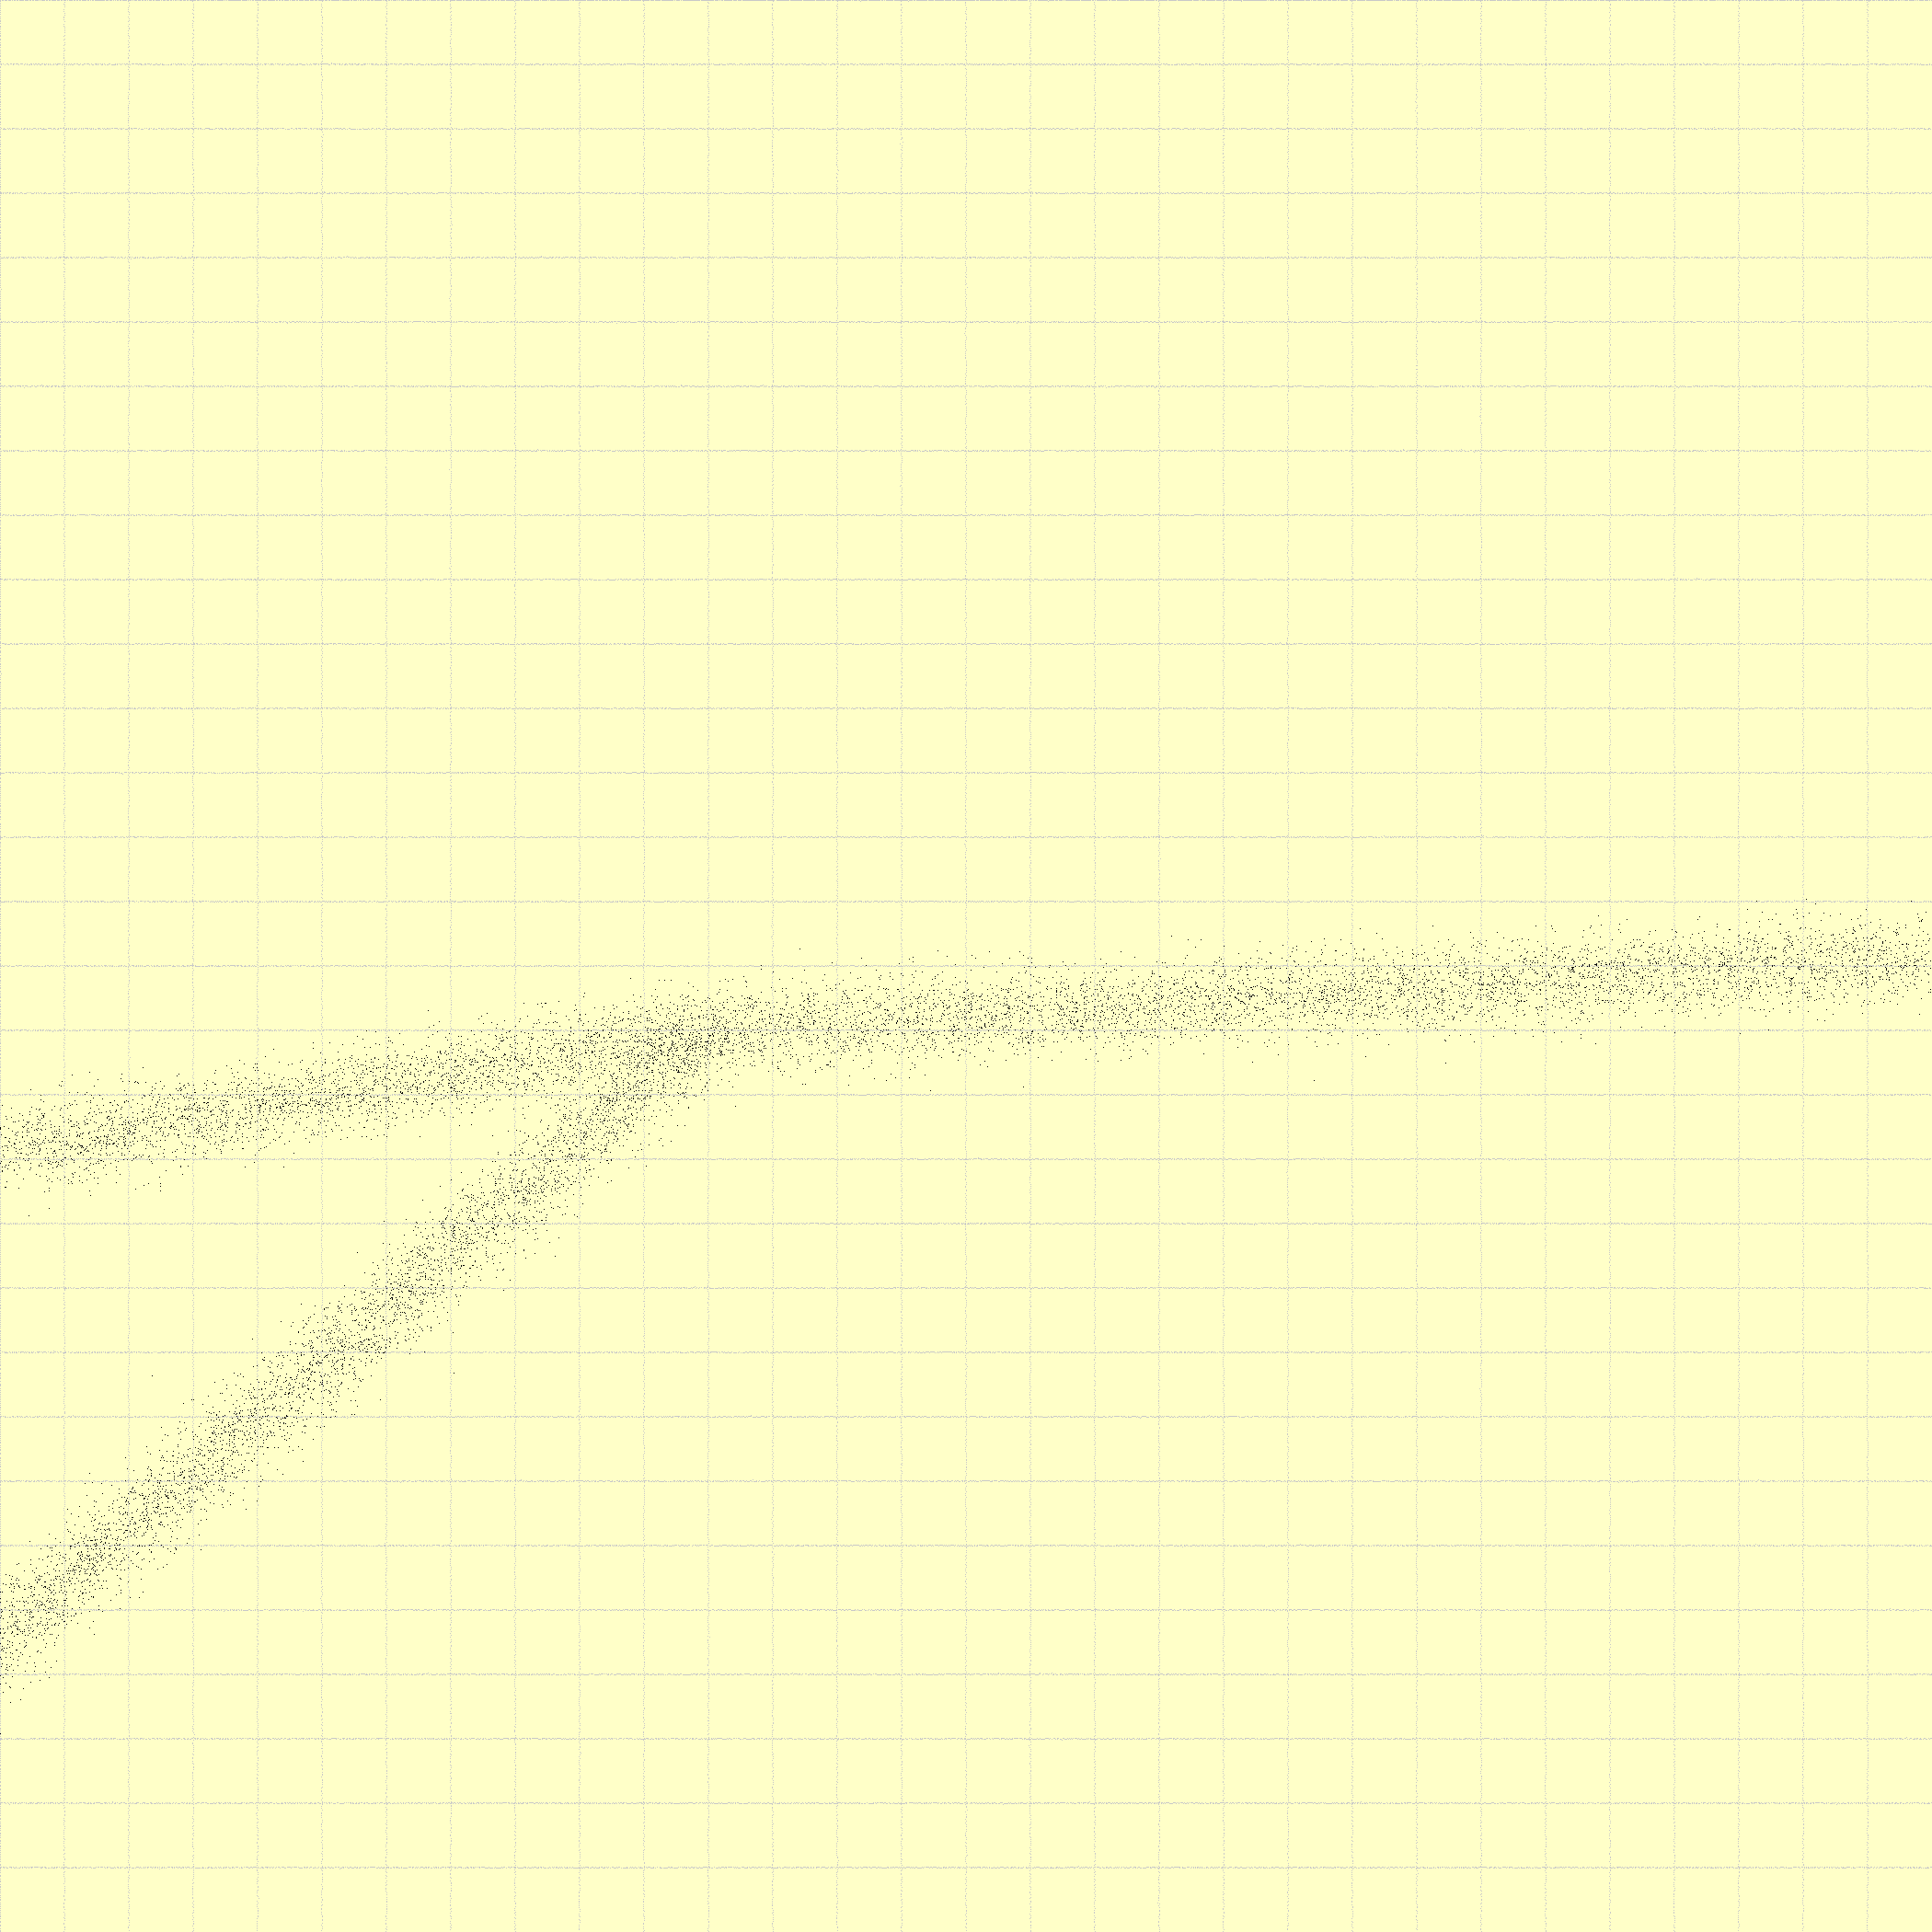

In [5]:
img = Image.new('RGB', (width_tiles*grid_square, height_tiles*grid_square), color = bg_colour)

rd.seed(seed=1)

drawGrid(width_tiles,height_tiles,grid_square)

townCentre = [int(rd.normal(loc=width_tiles/2,scale=width_tiles/6)), \
             int(rd.normal(loc=height_tiles/2,scale=height_tiles/6))]

tilemap=np.zeros((width_tiles,height_tiles))
tilemap[townCentre[0],townCentre[1]]=10 #using 10 to mark towncentre

roads = generateRoads(img,townCentre,grid_square,width_tiles,height_tiles,roadDirections=['W','E','S'])

drawCoords(roads,img)

img


In [30]:
def generateTileRoads(townCentre,width_tiles,height_tiles,grid_square,roadDirections=['W']):
    """
    road directions must be a list
    """
    
    coordlist = []
    jitterCoords = [] 
    for roadDirection in roadDirections:
        #assign starting coordinate of road as normally distributed position on appropriate edge
        #left for W, top for N, right for E, down for S
        if(roadDirection == 'N'):
            startCoord = [rd.normal(loc=townCentre[0],scale=width_tiles/3),0]
        elif(roadDirection == 'E'):
            startCoord = [width_tiles,rd.normal(loc=townCentre[1],scale=height_tiles/3)]
        elif(roadDirection == 'S'):
            startCoord = [rd.normal(loc=townCentre[0],scale=width_tiles/3),height_tiles]          
        elif(roadDirection == 'W'):
            startCoord = [0,rd.normal(loc=townCentre[1],scale=height_tiles/3)]
        
        #convert float coord to int as used to index image
        startCoord[0] = int(startCoord[0])
        startCoord[1] = int(startCoord[1])
        
        endCoord = townCentre
        
        #jitterCoords are to print in the line
        jitterCoords += jitteryLine([startCoord[0]*grid_square,startCoord[1]*grid_square],\
                                    [endCoord[0]*grid_square,endCoord[1]*grid_square],\
                                    spread=2*grid_square,weight=4)
        
        x_length = endCoord[0]-startCoord[0]
        y_length = endCoord[1]-startCoord[1]
        try: m = y_length/x_length #gradient
        except: m=None

        mean_length= int((abs(x_length)+abs(y_length)/2))

        if(m==None):
            for y in np.linspace(startCoord[1],endCoord[1],num=mean_length):
                x = startCoord[0]
                coordlist.append([int(x),int(y)])
        else:
            for x in np.linspace(startCoord[0],endCoord[0],num=mean_length):
                y = m*x-m*startCoord[0]+startCoord[1] #equation of line
                coordlist.append([int(x),int(y)]) 
    
    return coordlist,jitterCoords

In [27]:
def drawTile(img,tileIndex,grid_square,color,spread=0):
    pixelStartX = tileIndex[0]*grid_square
    pixelStartY = tileIndex[1]*grid_square
    pixelEndX = pixelStartX + grid_square
    pixelEndY = pixelStartY + grid_square
    
    for x in range(pixelStartX,pixelEndX):
        for y in range(pixelStartY,pixelEndY):
            if(spread>0):
                x1 = int(rd.normal(loc=x,scale=spread))
                y1 = int(rd.normal(loc=y,scale=spread))
            else: #hack to prevent x drifting during iterations
                x1=x
                y1=y
            
            if (y1 >= img.height or y1 < 0 or x1 >= img.width or x1 < 0):
                pass
            else:
                img.putpixel((x1,y1),color)

In [8]:
def renderTileMap(tilemap,img,height_tiles,width_tiles,grid_square):
    for row,tiles in enumerate(tilemap):
        for col,tile in enumerate(tiles):
            if(tile == 10):
                drawTile(img,[row,col],grid_square,(0,0,0),spread=grid_square/2)
            if(tile == 2):
                drawTile(img,[row,col],grid_square,(0,0,0))
            else:
                pass
            

    


In [ ]:
def genHouse(tilemap,width_tiles,height_tiles,grid_square):
    for row,tiles in enumerate(tilemap):
        for col,tile in enumerate(tiles):
            if(tile == 10):
                drawTile(img,[row,col],grid_square,(0,0,0),spread=grid_square/2)
            if(tile == 2):
                #pass
                drawTile(img,[row,col],grid_square,(0,0,0))
            else:
                pass
    

[15, 16]


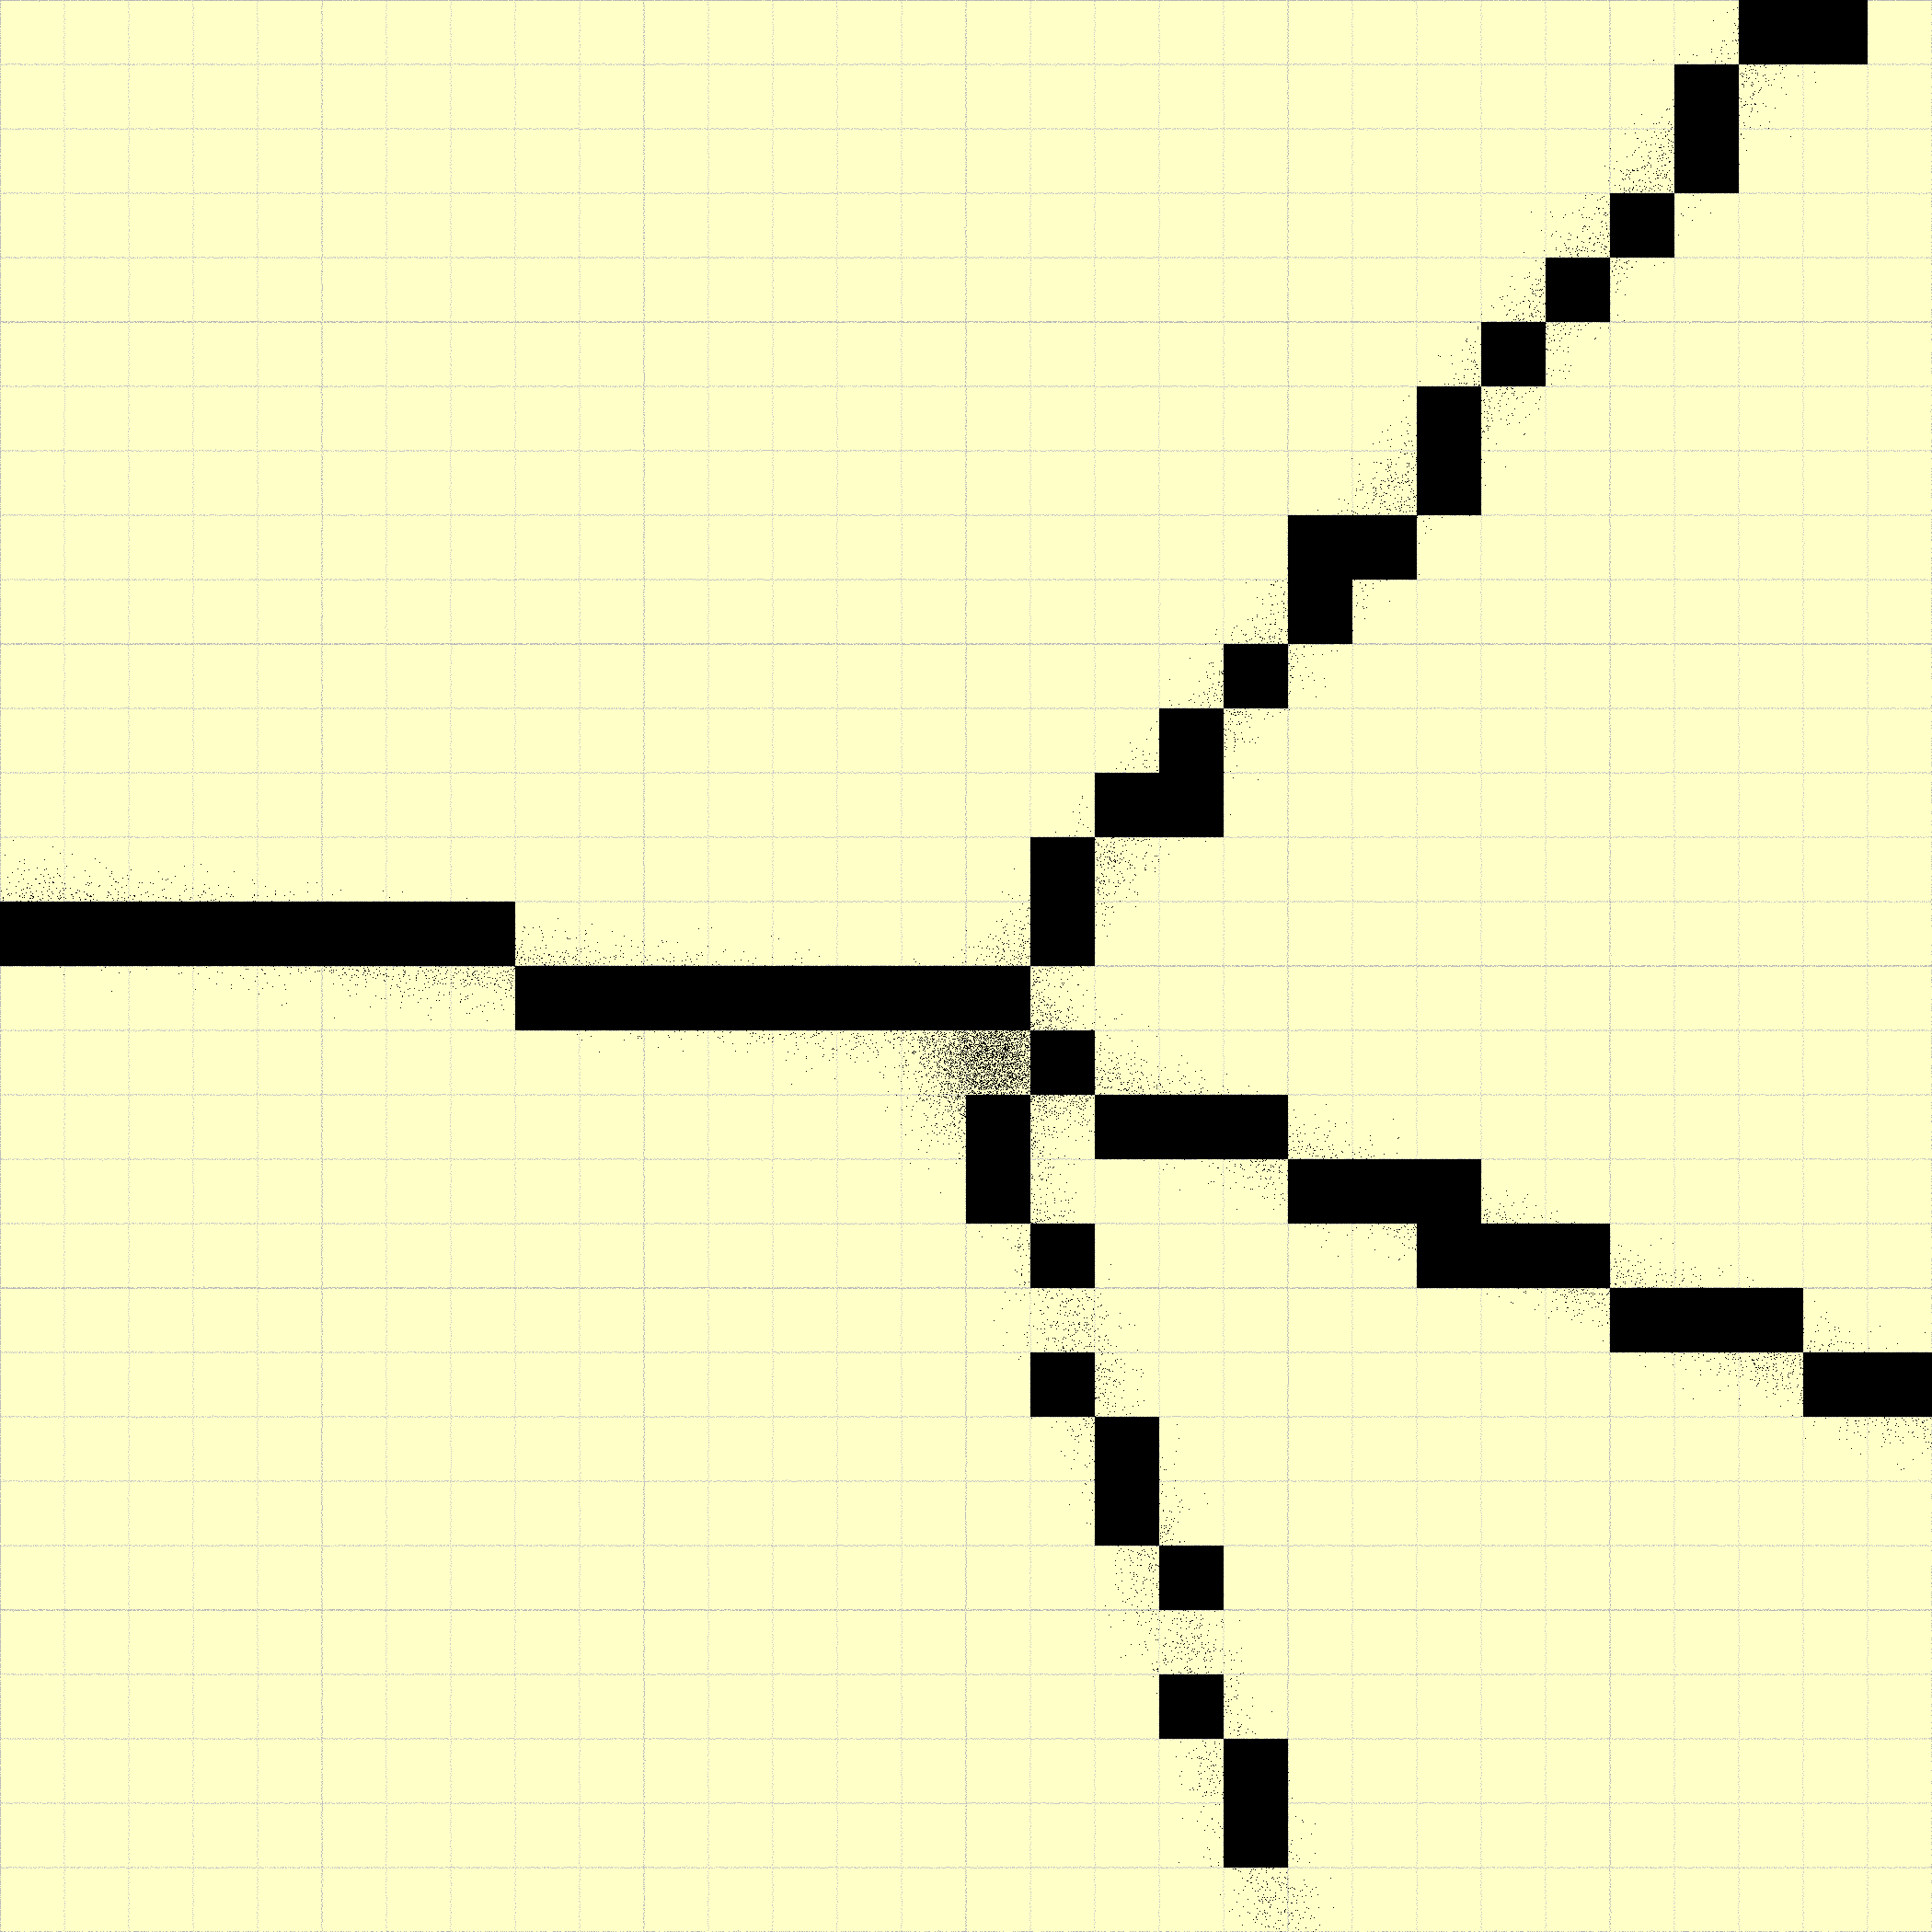

In [34]:
img = Image.new('RGB', (width_tiles*grid_square, height_tiles*grid_square), color = bg_colour)
rd.seed(4)
townCentre = [int(rd.normal(loc=width_tiles/2,scale=width_tiles/8)), \
             int(rd.normal(loc=height_tiles/2,scale=height_tiles/8))]

tilemap=np.zeros((width_tiles,height_tiles))
tilemap[townCentre[0],townCentre[1]]=10 #using 10 to mark towncentre

drawGrid(width_tiles,height_tiles,grid_square)
drawGrid(width_tiles,height_tiles,grid_square*5,color=(180,180,180)) #major grid

tilemapRoads,roadJitter = generateTileRoads(townCentre,width_tiles,height_tiles,\
                                             grid_square,roadDirections=['E','W','N','S'])

#assign roads to all tilemap coords.
for coord in tilemapRoads:
    if (coord[0]==tilemap.shape[0] or coord[1]==tilemap.shape[1]): continue
    
    if(tilemap[coord[0],coord[1]] == 0):
        tilemap[coord[0],coord[1]] = 2 #using 2 to mark road

renderTileMap(tilemap,img,height_tiles,width_tiles,grid_square)
drawCoords(roadJitter,img)
print(townCentre)
img


In [80]:
def tensorfield(tilemap):
    tensors = []
    for row,tiles in enumerate(tilemap):
            for col,tile in enumerate(tiles):
                theta = 0
                l = 1
                tensor = l * np.array([[np.cos(2*theta),np.sin(2*theta)],[np.sin(2*theta),-np.cos(2*theta)]])
                tensors.append(tensor)
    tensors = np.array(tensors)
    return(tensors.reshape((30,30,2,2)))

In [81]:
tensormap = tensorfield(tilemap)

In [82]:
tilemap.shape[0]

30

In [86]:
def roadDirections(tilemap,townCentre,roadDirections=['W']):
    """
    road directions must be a list
    """
    width_tiles = tilemap.shape[0]
    height_tiles = tilemap.shape[0]
    
    directions = np.zeros((30,30,2))
    for roadDirection in roadDirections:
        #assign starting coordinate of road as normally distributed position on appropriate edge
        #left for W, top for N, right for E, down for S
        if(roadDirection == 'N'):
            startCoord = [rd.normal(loc=townCentre[0],scale=width_tiles/3),0]
        elif(roadDirection == 'E'):
            startCoord = [width_tiles,rd.normal(loc=townCentre[1],scale=height_tiles/3)]
        elif(roadDirection == 'S'):
            startCoord = [rd.normal(loc=townCentre[0],scale=width_tiles/3),height_tiles]          
        elif(roadDirection == 'W'):
            startCoord = [0,rd.normal(loc=townCentre[1],scale=height_tiles/3)]
        
        #convert float coord to int as used to index
        startCoord[0] = int(startCoord[0])
        startCoord[1] = int(startCoord[1])
        
        endCoord = townCentre
        
        x_length = endCoord[0]-startCoord[0]
        y_length = endCoord[1]-startCoord[1]
        
        currentCoord = startCoord
        while (currentCoord != endCoord):
                direction = np.array([x_length,y_length])/(x_length**2 + y_length**2)**0.5
                directions[currentCoord[0],currentCoord[1]] = direction
                newCoord = currentCoord 
                while(newCoord = currentCoord):
                    newCoord += direction
                
    return directions

In [87]:
roadDirections(tilemap,townCentre)

array([[[ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        ...,
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054]],

       [[ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        ...,
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054]],

       [[ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        ...,
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054]],

       ...,

       [[ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        ...,
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65493054]],

       [[ 0.75568908, -0.65493054],
        [ 0.75568908, -0.65